In [111]:
import os
import pandas as pd
import seaborn as sns
import functions.token_functions as tf
import spacy
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords

In [112]:
nlp = spacy.load('en_core_web_sm')
sw = stopwords.words("english")

In [113]:
# Create an empty list to store the review dataframes
df_list = []
csv_files = os.listdir('../data/games',)

# Iterate over each file in the folder
for file in csv_files:
    # Read the CSV file into a datadrame
    df = pd.read_csv('../data/games/'+file, index_col=0)

    # Append the dataframe to the list
    df_list.append(df)

# Combine the dataframes into a single dataframe
games_df = pd.concat(df_list, ignore_index=True)


In [114]:
# drop values
games_df = games_df.dropna()

# drop non english reviews
games_df['lang'] = games_df['review'].apply(tf.detect_language)

games_df = games_df.query('lang == "en"')


In [115]:
games_df['review_tokens'] = games_df['review'].apply(tf.clean_tokenize)
games_df['review_title_tokens'] = games_df['review_title'].apply(tf.clean_tokenize)

In [116]:
games_df.groupby(['rating'])['review'].count()

rating
1.0    357
2.0     68
3.0     81
4.0    108
5.0    671
Name: review, dtype: int64

In [117]:
games_df['sentiment'] = 0
games_df.loc[games_df['rating']>3, 'sentiment'] = 1
games_df.loc[games_df['rating']<=3, 'sentiment'] = 0

<AxesSubplot:xlabel='sentiment', ylabel='count'>

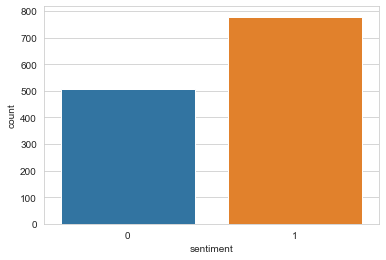

In [118]:
sns.countplot(x=games_df['sentiment'])

## Split Data

In [119]:
#high_low_df = games_df.query('rating == 1 | rating ==5')
#high_low_df.shape

In [120]:
#X = high_low_df[['review_tokens', 'review_title_tokens']]
#y = high_low_df['rating']

In [121]:
X_train, X_test, y_train, y_test = train_test_split(games_df['review'], games_df['sentiment'], test_size=0.20, random_state=10, stratify=games_df['sentiment'])

In [122]:
tf.sentiment_stats(X_train, X_test, y_train, y_test)

Size of Training Data  1028
Size of Test Data  257
Distribution of classes in Training Data :
Positive Sentiment  60.60311284046692
Negative Sentiment  39.39688715953307
Distribution of classes in Testing Data :
Positive Sentiment  60.70038910505836
Negative Sentiment  39.29961089494164


## Vectorize Data

In [123]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,1),stop_words=sw)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

## Train Sentiment Model

In [124]:
svc_model = LinearSVC(random_state=10, tol=1e-5)
svc_model.fit(X_train_tf, y_train)

LinearSVC(random_state=10, tol=1e-05)

In [125]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
y_pred = svc_model.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(y_test, y_pred))
print ('ROC-AUC Score - ', roc_auc_score(y_test, y_pred))

Accuracy Score -  0.7898832684824902
ROC-AUC Score -  0.7693259710586442


## Sample Predictions

In [126]:
sample_reviews = games_df.sample(5)
sample_reviews_tf = tfidf.transform(sample_reviews['review'])
sentiment_predictions = svc_model.predict(sample_reviews_tf)
sentiment_predictions = pd.DataFrame(data = sentiment_predictions,
                                     index=sample_reviews.index,
                                     columns=['sentiment_prediction'])
sample_reviews = pd.concat([sample_reviews, sentiment_predictions], axis=1)
print ('Some sample reviews with their sentiment - ')
sample_reviews[['review','sentiment_prediction']]

Some sample reviews with their sentiment - 


,review,sentiment_prediction
199,Playing on series x. Game is not as good as or...,1
804,"I bought this as a gift for my boyfriend, who ...",0
1060,First sonic game probably since the genesis. I...,0
149,My kids are looking forward to having Just Dan...,0
83,Not Saints Row.,0


## Pickle Models

In [128]:
with open('../models/svc_model.pkl', 'wb') as file:
    pickle.dump(svc_model, file)

with open('../models/tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)